In [1]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 데이터 경로 설정
CLICKBAIT_DIR = "/content/drive/My Drive/Colab Notebooks/samplebait/Clickbait/EC"
NONCLICKBAIT_DIR = "/content/drive/My Drive/Colab Notebooks/samplebait/NonClickbait/EC"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# JSON 파일 로드 함수
def load_json_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                content = json.load(f)
                title = content["sourceDataInfo"]["newsTitle"]
                label = content["labeledDataInfo"]["clickbaitClass"]
                data.append((title, label))
    return data

In [5]:
# 데이터 로드
clickbait_data = load_json_files(CLICKBAIT_DIR)
nonclickbait_data = load_json_files(NONCLICKBAIT_DIR)

In [6]:
# DataFrame 생성
df = pd.DataFrame(clickbait_data + nonclickbait_data, columns=["title", "label"])

In [7]:
# 데이터 분할
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["title"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [8]:
# BERT Tokenizer 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
# 데이터셋 클래스 정의
class ClickbaitDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
        self.texts[idx],
        padding="max_length",
        truncation=True,
        max_length=self.max_len,
        return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [10]:
# 데이터로더 설정
train_dataset = ClickbaitDataset(train_texts, train_labels, tokenizer)
test_dataset = ClickbaitDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
# 모델 설정
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
# 모델 학습
EPOCHS = 6
for epoch in range(EPOCHS):
    idx = 0
    print("현재 에포크", epoch)
    model.train()
    total_loss = 0
    for batch in train_loader:
        print("몇번째 배치", idx)
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        idx += 1
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

현재 에포크 0
몇번째 배치 0
몇번째 배치 1
몇번째 배치 2
몇번째 배치 3
몇번째 배치 4
몇번째 배치 5
몇번째 배치 6
몇번째 배치 7
몇번째 배치 8
몇번째 배치 9
몇번째 배치 10
몇번째 배치 11
몇번째 배치 12
몇번째 배치 13
몇번째 배치 14
몇번째 배치 15
몇번째 배치 16
몇번째 배치 17
몇번째 배치 18
몇번째 배치 19
몇번째 배치 20
몇번째 배치 21
몇번째 배치 22
몇번째 배치 23
몇번째 배치 24
몇번째 배치 25
몇번째 배치 26
몇번째 배치 27
몇번째 배치 28
몇번째 배치 29
몇번째 배치 30
몇번째 배치 31
몇번째 배치 32
몇번째 배치 33
몇번째 배치 34
몇번째 배치 35
몇번째 배치 36
몇번째 배치 37
몇번째 배치 38
몇번째 배치 39
몇번째 배치 40
몇번째 배치 41
몇번째 배치 42
몇번째 배치 43
몇번째 배치 44
몇번째 배치 45
몇번째 배치 46
몇번째 배치 47
몇번째 배치 48
몇번째 배치 49
몇번째 배치 50
몇번째 배치 51
몇번째 배치 52
몇번째 배치 53
몇번째 배치 54
몇번째 배치 55
몇번째 배치 56
몇번째 배치 57
몇번째 배치 58
몇번째 배치 59
몇번째 배치 60
몇번째 배치 61
몇번째 배치 62
몇번째 배치 63
몇번째 배치 64
몇번째 배치 65
몇번째 배치 66
몇번째 배치 67
몇번째 배치 68
몇번째 배치 69
몇번째 배치 70
몇번째 배치 71
몇번째 배치 72
몇번째 배치 73
몇번째 배치 74
몇번째 배치 75
몇번째 배치 76
몇번째 배치 77
몇번째 배치 78
몇번째 배치 79
몇번째 배치 80
몇번째 배치 81
몇번째 배치 82
몇번째 배치 83
몇번째 배치 84
몇번째 배치 85
몇번째 배치 86
몇번째 배치 87
몇번째 배치 88
몇번째 배치 89
몇번째 배치 90
몇번째 배치 91
몇번째 배치 92
몇번째 배치 93
몇번째 배치 94
몇번째 배치 95
몇번째 배치 96
몇번째 배치 97
몇번째 배치 98
몇번째 배치 99
몇

In [14]:
# 모델 평가
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [15]:
# 결과 출력
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))

Accuracy: 0.6660341555977229
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.61      0.65       538
           1       0.64      0.73      0.68       516

    accuracy                           0.67      1054
   macro avg       0.67      0.67      0.67      1054
weighted avg       0.67      0.67      0.66      1054



In [16]:
# 모델을 평가 모드로 전환
model.eval()

# 토크나이저 로드 (미리 사용한 것과 동일한 모델로 로드)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def predict_clickbait(title):
    # 입력 데이터 토큰화
    inputs = tokenizer(title, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # GPU 사용 가능하면 이동
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # 모델 예측 수행
    with torch.no_grad():
        outputs = model(**inputs)

    # 예측값 변환 (로직 → 확률 → 클래스)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # 출력
    label_map = {0: "Non-Clickbait", 1: "Clickbait"}
    print(f"입력 제목: {title}")
    print(f"예측 결과: {label_map[predicted_class]} (확률: {probabilities.squeeze().tolist()})")

# 샘플 테스트
sample_titles = [
    "공공구매에 사회가치 본격 반영",
    "국민연금 못받는 20대",
    "이재명 중국 귀화, 리짜오밍으로 개명까지"
]

for title in sample_titles:
    predict_clickbait(title)


입력 제목: 공공구매에 사회가치 본격 반영
예측 결과: Non-Clickbait (확률: [0.9642224311828613, 0.03577754274010658])
입력 제목: 국민연금 못받는 20대
예측 결과: Non-Clickbait (확률: [0.9635102152824402, 0.03648976981639862])
입력 제목: 이재명 중국 귀화, 리짜오밍으로 개명까지
예측 결과: Clickbait (확률: [0.07306627184152603, 0.9269337058067322])


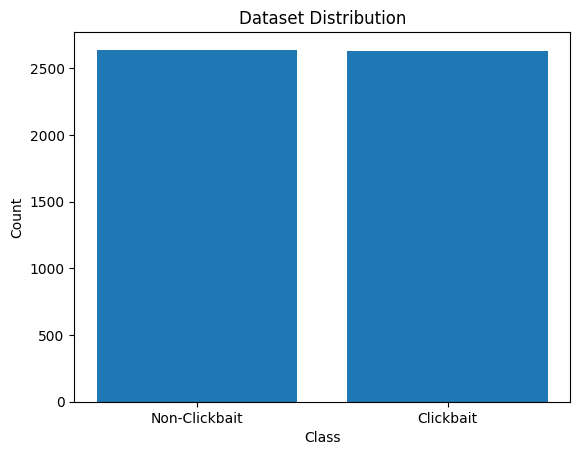

In [17]:
import matplotlib.pyplot as plt

# 데이터 라벨 분포 확인
label_counts = df["label"].value_counts()
plt.bar(["Non-Clickbait", "Clickbait"], label_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Dataset Distribution")
plt.show()

In [18]:
# 학습된 모델 저장
torch.save(model.state_dict(), "clickbait_model.pt")

# 토크나이저 저장
tokenizer.save_pretrained("tokenizer_dir")

('tokenizer_dir/tokenizer_config.json',
 'tokenizer_dir/special_tokens_map.json',
 'tokenizer_dir/vocab.txt',
 'tokenizer_dir/added_tokens.json')

In [19]:
import os

# 저장된 모델 파일이 있는지 확인
model_path = "clickbait_model.pt"

if os.path.exists(model_path):
    print(f"✅ Model file exists: {model_path}")
else:
    print("❌ Model file NOT found! Check the save path.")

✅ Model file exists: clickbait_model.pt


In [20]:
import os

# 모델 파일 이름
model_filename = "clickbait_model.pt"
tokenizer_dir = "tokenizer_dir"

# 모델 경로 확인
model_path = os.path.abspath(model_filename)
tokenizer_path = os.path.abspath(tokenizer_dir)

print(f"📌 Model path: {model_path}")
print(f"📌 Tokenizer path: {tokenizer_path}")


📌 Model path: /content/clickbait_model.pt
📌 Tokenizer path: /content/tokenizer_dir


In [21]:
from google.colab import drive
import os
import torch

# Google Drive 마운트
drive.mount('/content/drive')

# Google Drive 경로
drive_path = "/content/drive/My Drive/Colab Notebooks/samplebait"
os.makedirs(drive_path, exist_ok=True)

# 모델 저장
torch.save(model.state_dict(), os.path.join(drive_path, "clickbait_model.pt"))

# 토크나이저 저장
tokenizer.save_pretrained(os.path.join(drive_path, "tokenizer_dir"))

print(f"✅ Model saved to: {drive_path}/clickbait_model.pt")
print(f"✅ Tokenizer saved to: {drive_path}/tokenizer_dir/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/My Drive/Colab Notebooks/samplebait/clickbait_model.pt
✅ Tokenizer saved to: /content/drive/My Drive/Colab Notebooks/samplebait/tokenizer_dir/
